# Testing Non-Linear Element in dQ=-0.1 Adjusted Lattice




**Parameters for SC Match**
- 20 mm-mrad emittance - KV distribution
- dQ = -0.03
- t = 0.1
 


## Imports

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import constants
from scipy.interpolate import interp1d
import tables
from mpi4py import MPI

sys.path.append('/home/vagrant/jupyter/beamsim/synergia/') #added specifically for nifak.radiasoft.org

In [3]:
from base_diagnostics import utils
from base_diagnostics import StandardBeam6D
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from base_diagnostics import lfplot
from base_diagnostics import latticework
from base_diagnostics import basic_calcs
from base_diagnostics import pltbunch
from base_diagnostics import elliptic_sp
from base_diagnostics import singleparticle
from base_diagnostics import options
from elliptic import EllipticBeam6D
from semiGaussian import SemiGaussian6D
#from standard import StandardBeam6D
import synergia
import synergia_workflow


## Load options and lattices

In [5]:
#load options for SC_test
from SC_test_options import opts

#================== Setting up logger and MPI comunicator ============================
#try:
#if True:
# this is the communicator object that will be used for MPI operations
comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

logger = synergia.utils.Logger(0)


if myrank == 0:
    print "my rank is 0"
else:
    print "not rank 0"

my rank is 0


In [6]:
#================== Load the lattice =======================

lattices = {}
dir_66 = '/home/vagrant/jupyter/beamsim/synergia/lattices/Iota6-6/'
dir_82 = '/home/vagrant/jupyter/beamsim/synergia/lattices/Iota8-2/'

lattices['t1_dQ03_1IO_82'] ="soft_lattice_1IO_dQ_03.madx" #t1 8.2 lattice adjusted for dQ = -0.1
lattices['t3_dQ03_1IO_82'] ="soft_lattice_nll_1IO_dQ_03.madx" #t1 8.2 lattice adjusted for dQ = -0.1

In [7]:
#================= Construct a Python dictionary of lattice stuff ==================
lattice_dict = {}

for keys in lattices.keys():
    lattice_dict[keys] = {} #instantiate sub dictionary
    lattice_dict[keys]['name'] = keys
    lattice_dict[keys]['location'] = lattices[keys]
    lattice_dict[keys]['lattice'] = synergia.lattice.MadX_reader().get_lattice("iota", lattices[keys])
    latticework.set_lattice_element_type(lattice_dict[keys]['lattice'],opts)

In [8]:
reference_particle = lattice_dict['t1_dQ03_1IO_82']['lattice'].get_reference_particle()
energy = reference_particle.get_total_energy()
opts.beta = reference_particle.get_beta()
opts.gamma = reference_particle.get_gamma()


#================== Setting up the options =======================
order = 1
nsteps_per_element = 4


opts.gridx = 32
opts.gridy = 32
opts.gridz = 1

n_macro = opts.macro_particles

nsteps = len(lattice_dict['t1_dQ03_1IO_82']['lattice'].get_elements())*nsteps_per_element
opts.steps = nsteps

#==================== Set up space charge solver ==========================

requested_stepper = opts.stepper
if opts.spacecharge:
    
    solver = opts.solver
    # space charge only works with the split operator stepper, or soelements 
    if (requested_stepper != "splitoperator") and (requested_stepper != "soelements"):
        requested_stepper = "soelements"
        print "Requested stepper changed to soelements for space charge"

    #force these
    gridx = 32
    gridy = 32
    gridz = 1
    grid = [gridx, gridy, gridz]

    print >>logger, "grid: ", grid

    #opts.comm_divide = None
    if opts.comm_divide:
        sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
    else:
        sc_comm = synergia.utils.Commxx(True)

    #sc_comm = synergia.utils.Commxx(True)
    if solver == "2dopen-hockney":
        coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)
    elif solver == "3dopen-hockney":
        # full signature for 3d_open_hockney constructor is
        # comm, grid, long_kicks, z_periodic, period, grid_entire_period,
        # nsigma

        coll_operator = synergia.collective.Space_charge_3d_open_hockney(sc_comm, grid, opts.long_kicks, False, 0.0, False, opts.nsigma)
    elif solver == "2dbassetti-erskine":
        coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()
    else:
        raise RuntimeError, "requested space charge operator %s invalid.  Must be either 2dopen-hockney or 3dopen-hockney"%opts.solver

    print "Using space charge solver ", solver
    print "Grid: ", gridx, " x ", gridy, " x ", gridz

else:
    coll_operator = synergia.simulation.Dummy_collective_operator("stub")
    print "No space charge solver used"

#opts.use_maps = 'none'
#now set element type and construct stepper
print "use maps for: {}".format(opts.use_maps)
print "requested_stepper: {}".format(requested_stepper)

        
#================== Setting up the stepper and lattice simulator =======================

for key in lattices.keys():
    
    current_lattice = lattice_dict[key]['lattice']
    lattice_dict[key]['stepper'] = latticework.generate_stepper(current_lattice,coll_operator, opts)
    lattice_dict[key]['lattice_simulator'] = lattice_dict[key]['stepper'].get_lattice_simulator()

Using space charge solver  2dopen-hockney
Grid:  32  x  32  x  1
use maps for: none
requested_stepper: splitoperator
Using split-operator stepper with  1368  steps/turn
Using split-operator stepper with  1368  steps/turn


In [9]:
#Check that chef propagation is used
lattice1 = lattice_dict['t3_dQ03_1IO_82']['lattice']
for elem in lattice1.get_elements():
    print elem.get_string_attributes()

{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{'extractor_type': 'chef_propagate'}
{

In [10]:
print "For t1 v8.2 lattice:" + str(lattice_dict['t1_dQ03_1IO_82']['lattice_simulator'].get_both_tunes())
print "For t3 v8.2 lattice:" + str(lattice_dict['t3_dQ03_1IO_82']['lattice_simulator'].get_both_tunes())

For t1 v8.2 lattice:(0.33198126380201476, 0.3305054281784201)
For t3 v8.2 lattice:(0.3611258865466478, 0.3305054281784201)


<IPython.core.display.Javascript object>


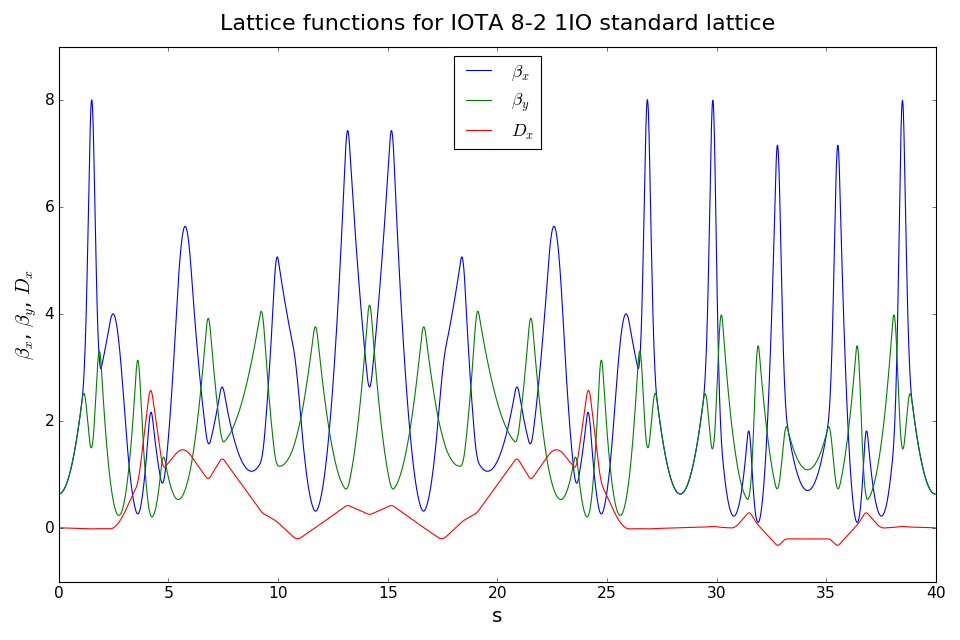

In [11]:
opts.save = False
opts.lattice_name = 'IOTA 8-2 1IO standard lattice'
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = lattice_dict['t1_dQ03_1IO_82']['lattice']
opts.lattice_simulator = lattice_dict['t1_dQ03_1IO_82']['lattice_simulator']
lfplot.plot_sliced_lattice_functions(opts)

# Get Initial Lattice Parameters for Use in Warp

In [12]:
#Initial twiss parameters from Synergia lattice
lf_names = ("beta_x", "alpha_x", "beta_y", "alpha_y", 
        "psi_x", "psi_y","D_x", "Dprime_x", "D_y", "Dprime_y")
lf = {}
for lfname in lf_names:
    lf[lfname] = np.empty([0,0])

for element in lattice_dict['t1_dQ03_1IO_82']['lattice'].get_elements():
    lattice_functions = lattice_dict['t1_dQ03_1IO_82']['lattice_simulator'].get_lattice_functions(element)
    for lfname in lf_names:
        lf[lfname] = np.append(lf[lfname],getattr(lattice_functions,lfname))

test11 = lattice_dict['t1_dQ03_1IO_82']['lattice']
test11.as_string
        
print "Initial parameters for lattice: \nbetax = %s\nbetay = %s\nalphax = %s\nalphay = %s" % (lf['beta_x'][0], lf['beta_y'][0],lf['alpha_x'][0],lf['alpha_y'][0])

Initial parameters for lattice: 
betax = 0.637322290643
betay = 0.637466372581
alphax = 0.00351216630292
alphay = -0.00138813301564


## Construct the beam and propagate it

In [13]:
opts.lattice = lattice_dict['t3_dQ03_1IO_82']['lattice']
opts.lattice_simulator = lattice_dict['t3_dQ03_1IO_82']['lattice_simulator']
opts.stepper = lattice_dict['t3_dQ03_1IO_82']['stepper']

In [14]:
def dQ_SC_Gauss(N,emit,ref):
    '''Return dQsc if given normalized emittance'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(4*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ

def dQ_SC_Gauss_2(N,emit,bet,gam):
    '''Return dQsc if given normalized emittance'''
    r0 = 1.54e-18 #classical proton radius
    
    dQ = -1.*r0*N/(4*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ


def dQ_SC_KV(N,emit,ref):
    '''Return dQsc for a KV beam if given normalized emittance (2x that of Gaussian)'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(2*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ


g_emit = 20.e-6 #TOTAL geometric emittance according to Sasha
n_emit = basic_calcs.calc_normalized_emittance(g_emit,opts.beta,opts.gamma)

current = 3.78 / 3.30 *1.e-3 #mA of current 
l_IOTA = 39.968229715800064 #length of lattice
rp_perlength = current/(reference_particle.get_beta()*scipy.constants.c*scipy.constants.e)
n_particles = rp_perlength*l_IOTA

dQ = dQ_SC_Gauss(n_particles,n_emit,reference_particle) #calc dQsc_x
dQ_KV = dQ_SC_KV(n_particles,n_emit,reference_particle) #calc dQsc_x

print "Assume a normalized total emittance of {} mm-mrad.".format(n_emit*1.e6)
print "At {} mA current, # of protons filling ring is {:e} or {:e} p+/cm.".format(current*1.e3,n_particles,n_particles/(100.*l_IOTA))
print "Corresponding space charge tune shift in x is {} for KV distribution".format(dQ_KV)

Assume a normalized total emittance of 1.46096398318 mm-mrad.
At 1.14545454545 mA current, # of protons filling ring is 1.308301e+10 or 3.273353e+06 p+/cm.
Corresponding space charge tune shift in x is -0.0299670512161 for KV distribution


In [15]:
#======================= Now setup the bunch and other related options =====================
tval = 0.1
cval = 0.01

opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
opts.nseg = 20
vals = basic_calcs.get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)

#specify vals for center of the section
#opts.betae = vals[3]
#opts.alphae = 0 #fixed 0 alpha for center
#opts.beta0 = vals[3]

#Get immediate beta value from lattice simulator and match to this instead
new_vals = latticework.get_starting_lf(lattice_dict['t1_dQ03_1IO_82']['lattice_simulator'])
opts.betae = new_vals[0]
opts.alphae = 0
opts.beta0 = new_vals[0]


#opts.dpop = 0.4/100 #0.4% dpop
dpop = 0.0
opts.dpop = dpop #0.1% dpop

rp_perlength = current/(opts.beta*constants.c*constants.e)
bunch_length = opts.lattice.get_length() #effective bunch length is iota lattice length
opts.real_particles = rp_perlength*bunch_length

opts.emit = 0.5 * g_emit# USE THE GEOMETRIC EMITTANCE!!!!
opts.emits = [opts.emit]


if myrank == 0:
    #construct a bunch and make sure to add longitudinal momentum variation
    #particles = SemiGaussian6D.semiGaussianBeam6D(opts)
    particles = EllipticBeam6D.toyEllipticalBeam6D(opts)#StandardBeam6D.toyKVBeam6D(opts)

    for index in range(len(opts.emits)):
        bunch = particles[index]
        #initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
        #bunch_mean = np.mean(initialH)
        #bunch_std = np.std(initialH)
        #bunch_var = (bunch_std/bunch_mean)*100
        #print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
        #now add longitudinal momentum variation
        #For random samples with mean = 0, sigma = sigma, use sigma*np.random.randn(...)
        #bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch))
        bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
        bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch)) #set dp/p

    np.savetxt('my_KV_bunch_82.txt',bunch)         #write the bunch to a text file


bucket_length = bunch_length
particles_file = 'my_KV_bunch_82.txt'
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myBunch.get_local_particles()
local_particles[:,4] /= opts.beta

Initial starting lattice functions: betax = 0.63749908308, betay = 0.637489465748, alphax = 0.00348916477111, alphay = -0.00141977457081
Loading Synergia particles from txt file:  my_KV_bunch_82.txt
Read  10000  particles


<IPython.core.display.Javascript object>


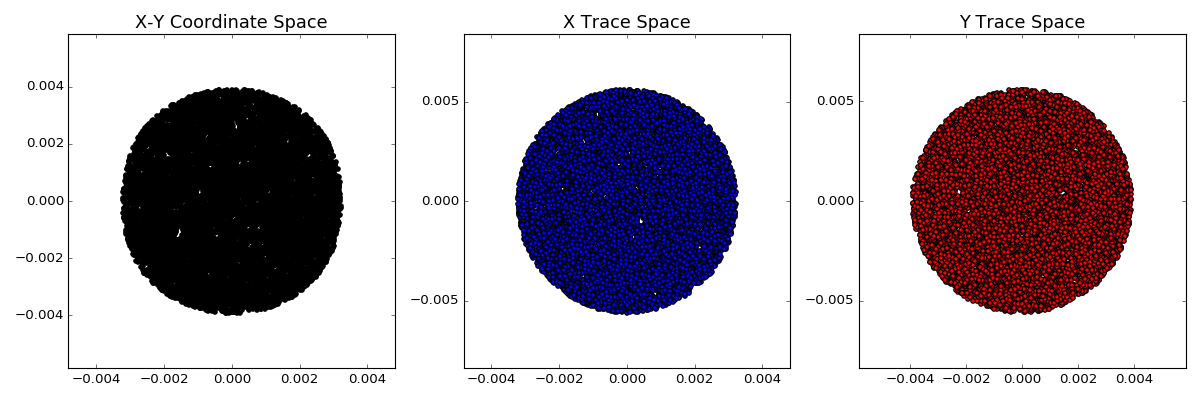

<IPython.core.display.Javascript object>


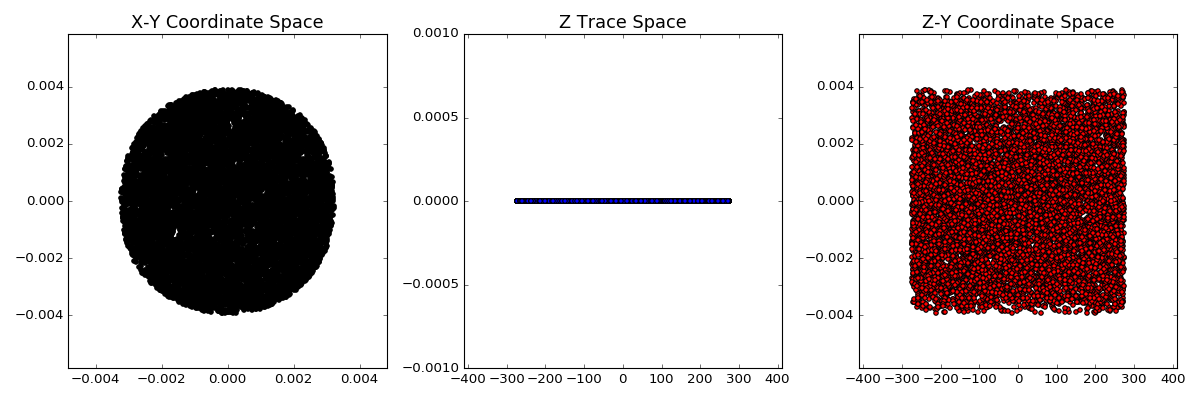

/home/vagrant/.pyenv/versions/2.7.10/lib/python2.7/site-packages/matplotlib/axes/_base.py:3025: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


In [16]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [25]:
basic_calcs.calc_properties(myBunch,reference_particle)

initialH,initialI = elliptic_sp.calc_bunch_H(myBunch,opts)
bunch_mean = np.mean(initialH)
bunch_std = np.std(initialH)
print "\nInitial H = %s\nstd of H = %s" % (bunch_mean,bunch_std)

rms envelope x: 1.63364836094 mm
rms envelope y: 1.98359264433 mm
maximum x value is : 3.21641250851 mm
maximum y value is : 3.89969228184 mm
rms beta x: 0.579688219798
rms beta y: 0.710408546698
geometric emittance x: 4.60386614055 mm-mrad
geometric emittance y: 5.5385591811 mm-mrad
normalized emittance x: 0.336304130737 mm-mrad
normalized emittance y: 0.404581774115 mm-mrad
mean of xp^2 : 7.94196946447e-06
mean of yp^2 : 7.79630144773e-06
total geometric emittance x: 17.8463337215 mm-mrad
total geometric emittance y: 21.4068369021 mm-mrad
Initial H = 1e-05
std of H = 2.48560515851e-21


In [17]:
outputdir = '8-2_dQm0p03_NLL'

opts.output_dir = outputdir
workflow.make_path(outputdir)

bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [ ]:
opts.turns = 1044
opts.checkpointperiod = 10
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(opts.stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

## Analysis

### Analysis - Beam Envelopes

In [19]:
from base_diagnostics import diagplot2

opts.output_dir = outputdir
opts.relpath = opts.output_dir

opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std']
plotVals = diagplot2.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

interval = opts.steps 
xstd_0 = xstd[:interval]
xstd_2 = xstd[1*interval:2*interval]
xstd_end = xstd[-1*interval:] 

ystd_0 = ystd[:interval]
ystd_end = ystd[-1*interval:] 

#We can use the same s value for each plot
sval_0 = xmaster[:interval]

<IPython.core.display.Javascript object>


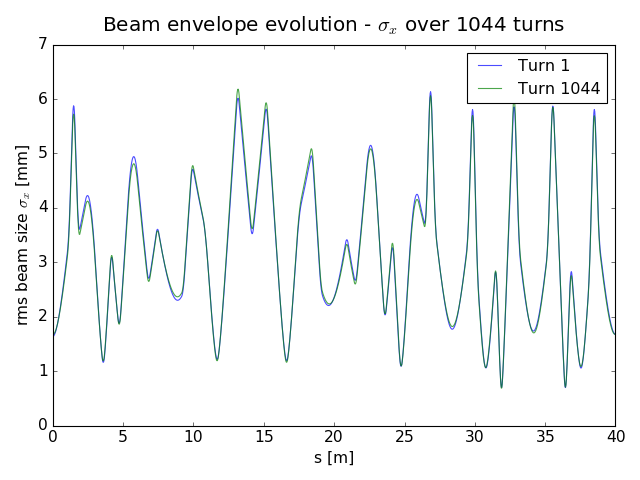

In [20]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,xstd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,xstd_2*1.e3,'g-',alpha=0.7, label='Turn %s' % opts.turns) #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_x$ over %s turns" % opts.turns
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

<IPython.core.display.Javascript object>


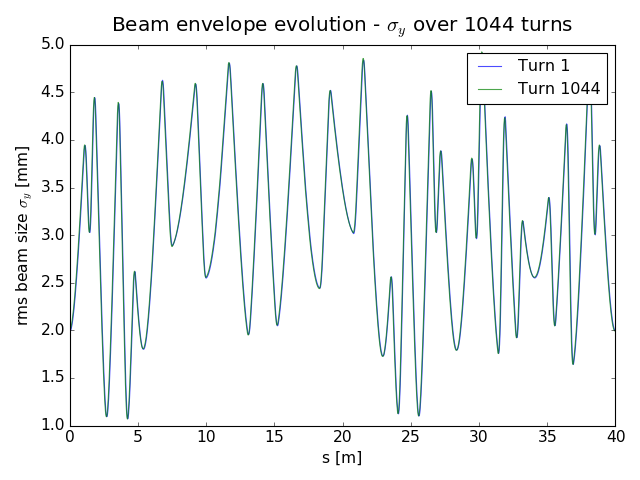

In [21]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,ystd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,ystd_end*1.e3,'g-',alpha=0.7, label='Turn %s' % opts.turns) #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_y$ over %s turns" % opts.turns
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_y$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

### Analysis - Bunch Properties

<IPython.core.display.Javascript object>


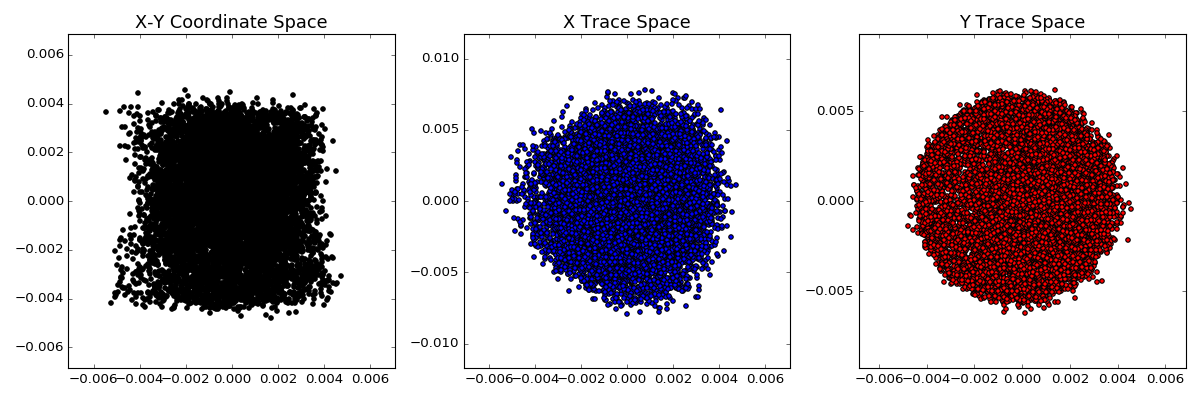

<IPython.core.display.Javascript object>


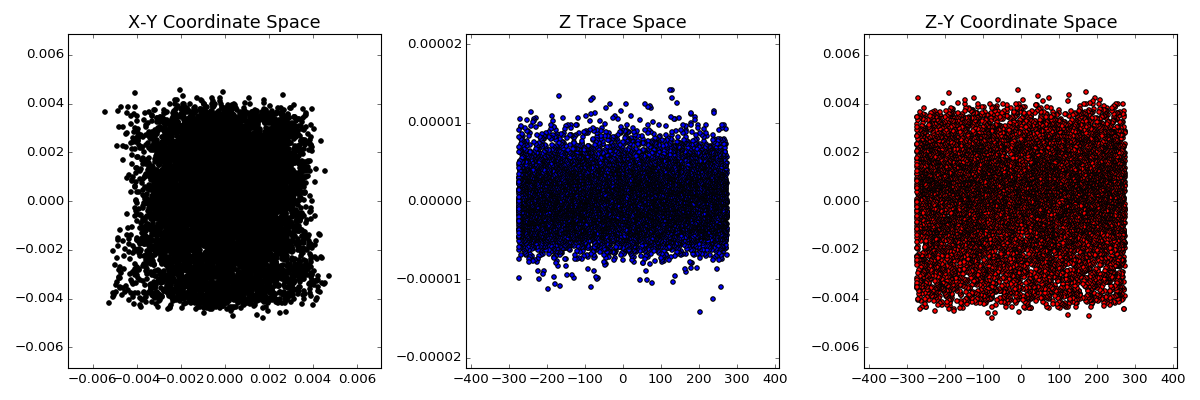

In [22]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [23]:
basic_calcs.calc_properties(myBunch,reference_particle)
initialH,initialI = elliptic_sp.calc_bunch_H(myBunch,opts)
bunch_mean = np.mean(initialH)
bunch_std = np.std(initialH)
print bunch_mean, bunch_std

rms envelope x: 1.7987558688 mm
rms envelope y: 1.99003338924 mm
maximum x value is : 4.73607875572 mm
maximum y value is : 4.57006963389 mm
rms beta x: 0.604374453457
rms beta y: 0.71374196633
geometric emittance x: 5.35350668287 mm-mrad
geometric emittance y: 5.54854986413 mm-mrad
normalized emittance x: 0.391064022369 mm-mrad
normalized emittance y: 0.405311575519 mm-mrad
mean of xp^2 : 8.85793013296e-06
mean of yp^2 : 7.77388765952e-06
total geometric emittance x: 37.1134846156 mm-mrad
total geometric emittance y: 29.2620266761 mm-mrad
1.07929963487e-05 5.87667273943e-06


myBunch.txt 8-2_dQm0p1_NLL
11


<IPython.core.display.Javascript object>


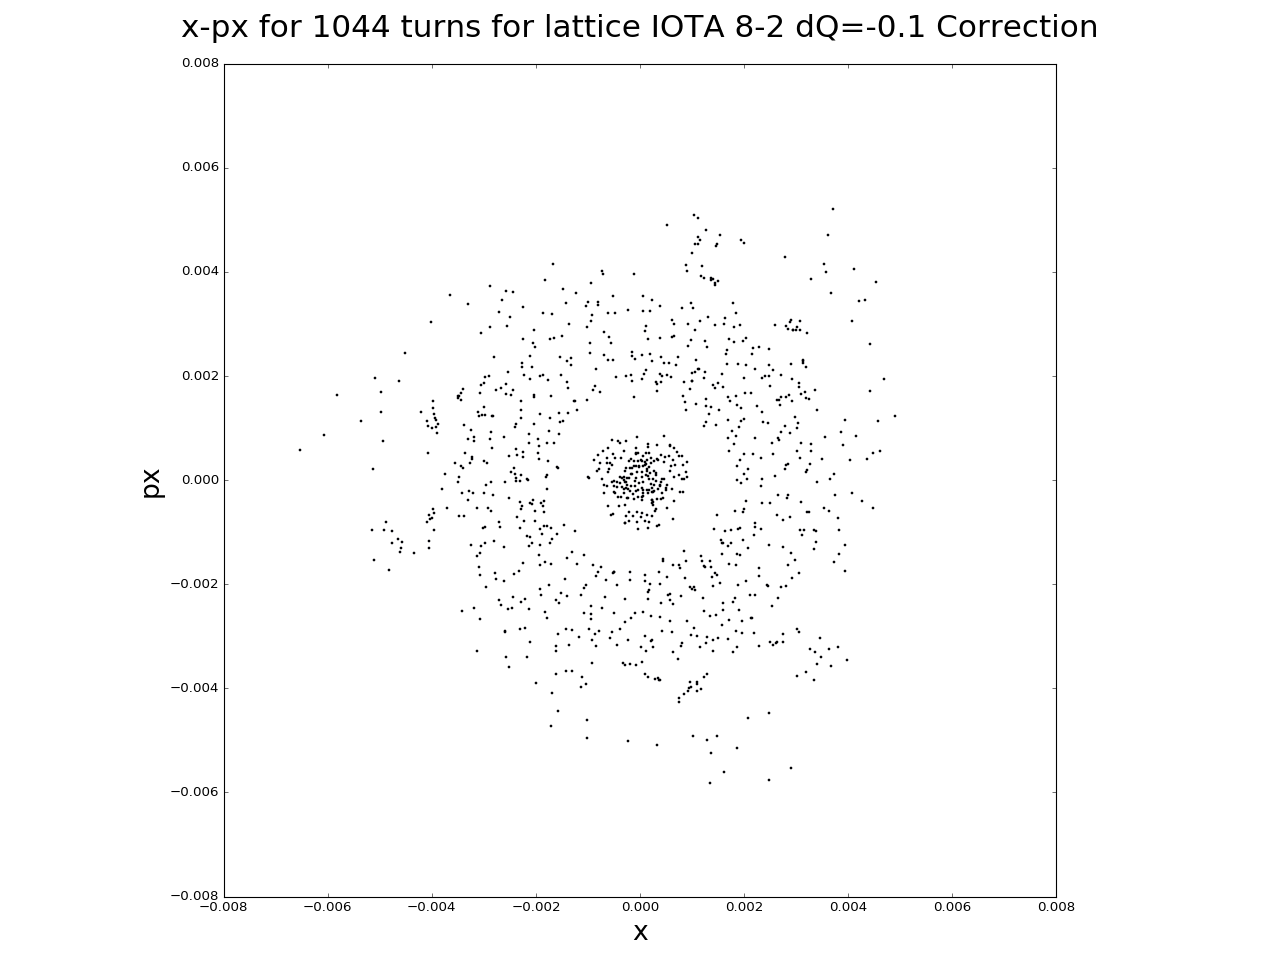

In [24]:
print opts.bunch_file, opts.relpath
print len(elliptic_sp.get_lost_particle_list(opts))
opts.plots = ['x','px']
opts.plot_lost = False
opts.lost = True
opts.num = 1
opts.scale = 2
opts.lattice_name = 'IOTA 8-2 dQ=-0.1 Correction'
opts.save = False
elliptic_sp.plot_Poincare(opts)

In [26]:
files = elliptic_sp.get_file_list(opts)
twiss = twiss = elliptic_sp.get_toy_twiss(opts)

rms_table = []


for inputfile in files:
    fn = inputfile[-7:-3]
    
    parts = elliptic_sp.get_particles(inputfile)[1]
    header= {}
    header['s_val'] = 0.
    #norm_coords = elliptic_sp.normalized_coordinates(header, part_array, twiss)
    
    x_rms = basic_calcs.get_rms_envelope('x',parts)
    y_rms = basic_calcs.get_rms_envelope('y',parts)
    
    rms_table.append((int(fn),x_rms,y_rms))
    
    #print "File {} : xrms = {:.2f} mm and yrms = {:.2f} mm".format(fn, x_rms*1.e3, y_rms*1.e3)
    
rms_array = np.asarray(rms_table)

<IPython.core.display.Javascript object>


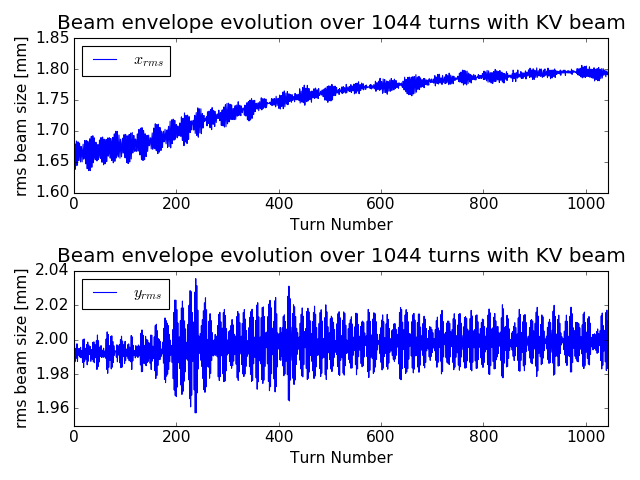

In [29]:
num_turns = rms_array.shape[0]-1

fig = plt.figure(figsize = (8,6))
plt.subplot(2,1,1)
ax = plt.gca()

ax.plot(rms_array[:,0],rms_array[:,1]*1000, label = '$x_{rms}$')

axtitle = "Beam envelope evolution over {} turns with KV beam".format(num_turns)
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("Turn Number",fontsize=14)
ax.set_ylabel("rms beam size [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,num_turns])
ax.legend(loc=2)
fig.tight_layout()

plt.subplot(2,1,2)
bx = plt.gca()
bx.plot(rms_array[:,0],rms_array[:,2]*1000, label = '$y_{rms}$')
bxtitle = "Beam envelope evolution over {} turns with KV beam".format(num_turns)
bx.set_title(bxtitle, y = 1.02, fontsize = 18)  
bx.set_xlabel("Turn Number",fontsize=14)
bx.set_ylabel("rms beam size [mm]",fontsize=14)
bx.tick_params(axis='x', labelsize=14)
bx.tick_params(axis='y', labelsize=14)
bx.set_xlim([0,num_turns])
bx.legend(loc=2)
fig.tight_layout()

plt.show()

### Analysis - Tune depression

In [30]:
def get_particle_coords(ID, num, opts):
    '''Return particle (human) coordinates for particle with ID over first num turns'''
    
    files = elliptic_sp.get_file_list(opts)
    twiss = elliptic_sp.get_toy_twiss(opts)

    part_array = []

    for index,outfile in enumerate(files[:num]):
        
        #if index%20 == 0:
            #print "Grabbing particle {} coordinates for file {}".format(ID,index)
    
        particle = elliptic_sp.get_one_particle(outfile,ID)
    
        if index ==0:
            part_array = particle
        else:
            part_array = np.vstack([part_array,particle])
            
    return part_array

def estimate_tune(x_c, t_s = 1):
    '''Estimate the tune using an FFT of particle coordinates'''
    
    num_used = len(x_c[t_s:])
    tv = np.arange(num_used)*1.0/num_used
    sp = np.fft.fft(x_c[t_s:])
    #plt.plot(tv,sp.real)


    smax = np.max(sp.real)
    m_ind = np.where(sp.real == smax)
    Q_guess =m_ind[0][0]*1./num_used
    if Q_guess > 0.5:
        Q_calc = 1.- Q_guess
    else:
        Q_calc = Q_guess
    #print "Maximum is at {}".format(Q_calc)
    return Q_calc

def estimate_tune_unwrap(x_c,px_c,t_s):
    '''Estimate the tune using a phase unwrap algorithm
    
    Inputs:
        -x_c = normalized spatial coordinate
        -px_c = normalized momentum cooridnate
        -t_s = starting turn value from the array of coordinates
    
    '''
    ang_norm = []
    for x,y in zip(x_c,px_c):
        if x > 0 and y > 0: #quandrant I
            ang_norm.append(np.arctan(y/x))
        elif x < 0 and y > 0: #quandrant II
            ang_norm.append(0.5*np.pi + (0.5*np.pi - np.abs(np.arctan(y/x))))
        elif x < 0 and y < 0: #quadrant III
            ang_norm.append(np.pi + np.abs(np.arctan(y/x)))
        else: #quadrant IV
            ang_norm.append(1.5*np.pi + (0.5*np.pi - np.abs(np.arctan(y/x))))

    #take diference between elements
    diff_ang = np.ediff1d(ang_norm)

    #adjust for wrapping by replacing positive values with 2pi-val
    dff_adjust = []
    for val in diff_ang:
        if val > 0:
            val = val - 2*np.pi
        dff_adjust.append(val)

    #now look at the last 50-80 turns
    #np.mean(dff_adjust[30:])
    t_s = 0
    meantune = -1*(np.mean(dff_adjust[t_s:]))/(2*np.pi)
    #print "{} is the mean tune for particle 0 after turn {}".format(meantune,t_s)
    return meantune

In [113]:
def get_some_particles(inputfile, ID=np.arange(100)):
    '''
    Reads an input file and returns a several particles' coordinates specified by particle ID.
    
    Arguments:
        inputfile (str): path to a .h5 file containing particle diagnostics.
        ID (Optional[list]): list of particle ID for the one particle to get. Defaults to [1:100]
        
    Returns:
        part_vals (ndArray): array of particle data [x, x', y, y', cdt, dp, ID] for each particle
    
    '''
    
    f = tables.openFile(inputfile, 'r')
    particles = f.root.particles.read()
    
    #get appropriate reference properties from file root
    npart = particles.shape[0]
    mass = f.root.mass[()]
    p_ref = f.root.pz[()]
    sn = f.root.s_n[()] #period length
    tn = f.root.tlen[()] #cumulative tracked length for this file

    f.close()
    
    #ID = np.arange(5000)
    
    header = dict()
    header['n_part'] = npart
    header['mass'] = mass
    header['p_ref'] = p_ref
    header['s_val'] = sn
    header['t_len'] = tn
    
    part_vals = []
    
    #separate lost particles
    for particle in particles:
        val = particle[6]
        if val in ID:
            part_vals.append(particle)
            
    return np.asarray(part_vals)


def get_n_particles(inputfile, ID=100):
    '''
    Reads an input file and returns a several particles' coordinates specified by particle ID.
    
    Arguments:
        inputfile (str): path to a .h5 file containing particle diagnostics.
        ID (Optional[list]): list of particle ID for the one particle to get. Defaults to [1:100]
        
    Returns:
        part_vals (ndArray): array of particle data [x, x', y, y', cdt, dp, ID] for each particle
    
    '''
    
    f = tables.openFile(inputfile, 'r')
    particles = f.root.particles.read()
    
    #get appropriate reference properties from file root
    npart = particles.shape[0]
    mass = f.root.mass[()]
    p_ref = f.root.pz[()]
    sn = f.root.s_n[()] #period length
    tn = f.root.tlen[()] #cumulative tracked length for this file

    f.close()
    
    #ID = np.arange(5000)
    
    header = dict()
    header['n_part'] = npart
    header['mass'] = mass
    header['p_ref'] = p_ref
    header['s_val'] = sn
    header['t_len'] = tn
    
    part_vals = []
    
    #separate lost particles
    for particle in particles:
        if len(part_vals) < ID:
            part_vals.append(particle)
        else:
            break
            
    return np.asarray(part_vals)

num_t = 1044
tune_array = []
part_array = []

twiss = twiss = elliptic_sp.get_toy_twiss(opts)
header= {}
header['s_val'] = 0.
files = elliptic_sp.get_file_list(opts)[:num_t]

IDlist = get_n_particles(files[-1],ID=400)[:,6]


for index,inputfile in enumerate(files):
    #get all of the particles specifed by IDlist
    p_A = get_some_particles(inputfile,IDlist)
    norm_coords = elliptic_sp.normalized_coordinates(header, p_A, twiss)
    if len(part_array) == 0:
        #if empty, then replace with norm_coords - first turn
        part_array = norm_coords
    else:
        part_array = np.vstack((part_array,norm_coords))
    
    
#reshape array to be indexable by ID number     
new_PA = part_array.reshape(num_t,len(IDlist),4)

x_tune_array = []
y_tune_array = []
for ID in range(len(IDlist)):
    x_tune_array.append(estimate_tune(new_PA[:,ID,0]))
    y_tune_array.append(estimate_tune(new_PA[:,ID,2]))

/home/vagrant/.pyenv/versions/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:59: DeprecationWarning: openFile() is pending deprecation, use open_file() instead. You may use the pt2to3 tool to update your source code.
/home/vagrant/.pyenv/versions/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: openFile() is pending deprecation, use open_file() instead. You may use the pt2to3 tool to update your source code.


<IPython.core.display.Javascript object>


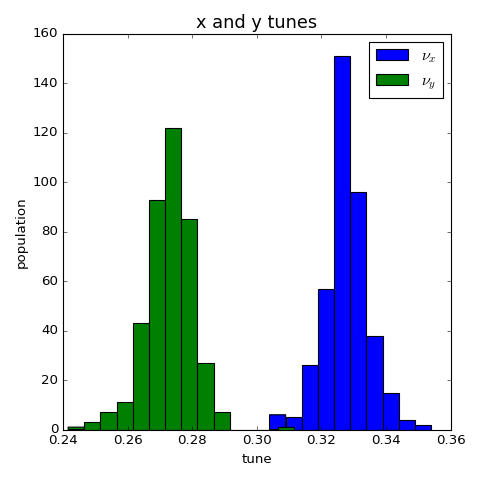

In [118]:
fig = plt.figure(figsize = (6,6))
ax = fig.gca()

binwidth=0.005
xbins = np.arange(min(x_tune_array), max(x_tune_array) + binwidth, binwidth)
ybins = np.arange(min(y_tune_array), max(y_tune_array) + binwidth, binwidth)

ax.hist(x_tune_array,xbins,label='$\\nu_x$')


bx = fig.gca()
bx.hist(y_tune_array,ybins,label='$\\nu_y$')

bx.legend()
bx.set_title('x and y tunes')
bx.set_xlabel('tune')
bx.set_ylabel('population')
plt.show()

# Analysis - Invariants

In [34]:
#Collect particles, sort and return array of invariants over all particles and turns
def lostlist(directory,npart):
    lostlist = []
    lastfile = sorted(os.listdir(directory))[-1]
    print lastfile
    header, bunchIn = elliptic_sp.get_particles(directory + '/' + lastfile)
    print bunchIn.shape
    for i in range(npart):
        if not np.any(bunchIn[:,6] == i):
            lostlist.append(i)
            
    return lostlist

def get_invariants(directory,npart):
    Harray = []
    Iarray = []
    lostParts = lostlist(directory,npart)

    for bunchFile in sorted(os.listdir(directory)):
        if bunchFile.endswith('.h5') and bunchFile.find('particles')!= -1:
            header, bunchIn = elliptic_sp.get_particles(directory + '/' + bunchFile)
            
            for lost in lostParts:
                rowlost = np.where(bunchIn[:,6] == lost)[0]
                try:
                    rowval = rowlost[0]
                except IndexError:
                    rowval = None
                if rowval:
                    bunchIn = np.delete(bunchIn,rowval,0)

                rowval = None
                
            sBunch = bunchIn[np.argsort(bunchIn[:,6])]
            Hval,Ival = elliptic_sp.calc_bunch_H(sBunch,opts)
            Harray.append(Hval)
            Iarray.append(Ival)
            
    return np.transpose(np.array(Harray)),np.transpose(np.array(Iarray))



In [35]:
Hinv, Iinv = get_invariants('8-2_dQm0p1_NLL',10000)

particles_1044.h5
(9989, 7)


<IPython.core.display.Javascript object>


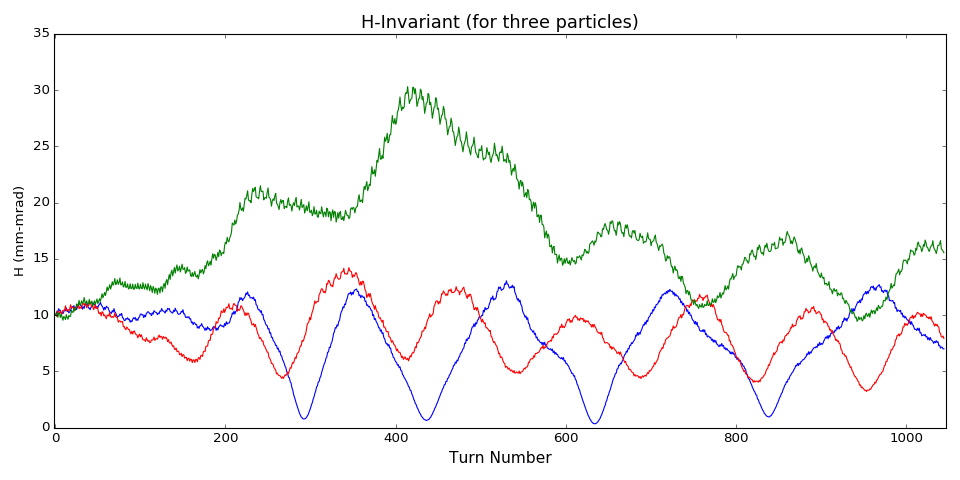

In [119]:
figc = plt.figure(figsize=(12,6))
cx = plt.gca()
cx.plot(np.arange(opts.turns+1),Hinv[0,:]*1e6,'-b')
cx.plot(np.arange(opts.turns+1),Hinv[50,:]*1e6,'-r')
cx.plot(np.arange(opts.turns+1),Hinv[4242,:]*1e6,'-g')
cx.set_xlim(-1,opts.turns+2)
cx.set_xlabel("Turn Number",fontsize=14)
cx.set_ylabel("H (mm-mrad)")
cx.set_title("H-Invariant (for three particles)")
plt.show()

<IPython.core.display.Javascript object>


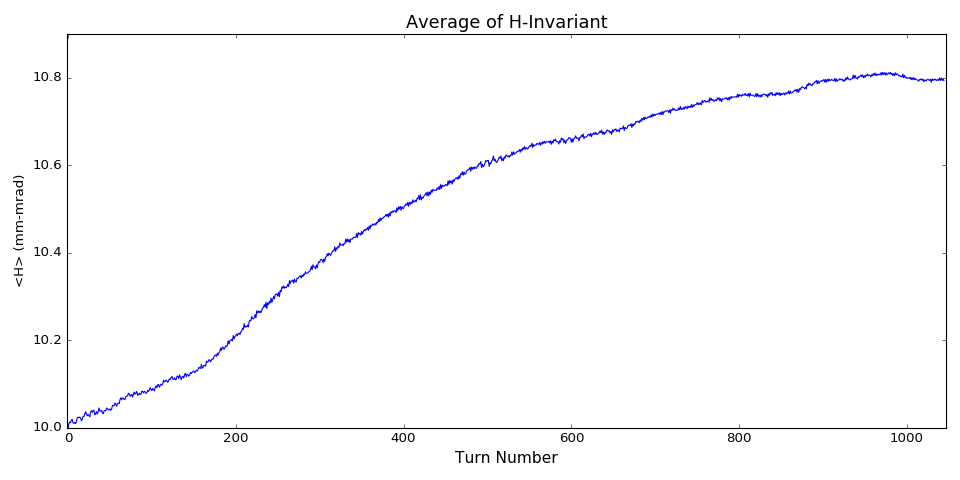

In [41]:
figc = plt.figure(figsize=(12,6))
cx = plt.gca()
cx.plot(np.arange(opts.turns+1),[np.average(Hinv[:,i])*1e6 for i in range(Hinv.shape[1])],'-')
cx.set_xlim(-1,opts.turns+2)
#cx.set_ylim(9.5,10.5)
cx.set_xlabel("Turn Number",fontsize=14)
cx.set_ylabel( "<H> (mm-mrad)")
cx.set_title("Average of H-Invariant")
plt.show()

<IPython.core.display.Javascript object>


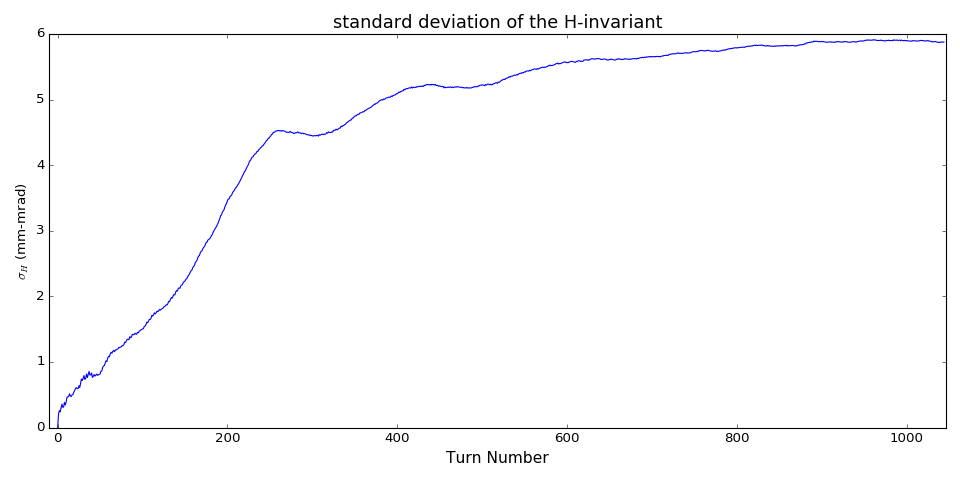

In [88]:
figc = plt.figure(figsize=(12,6))
cx = plt.gca()
cx.plot(np.arange(opts.turns+1),[np.std(Hinv[:,i])*1e6 for i in range(Hinv.shape[1])],'-')
cx.set_xlim(-10,opts.turns+2)
cx.set_xlabel("Turn Number",fontsize=14)
cx.set_ylabel("$\sigma_H$ (mm-mrad)")
cx.set_title("standard deviation of the H-invariant")
plt.show()

<IPython.core.display.Javascript object>


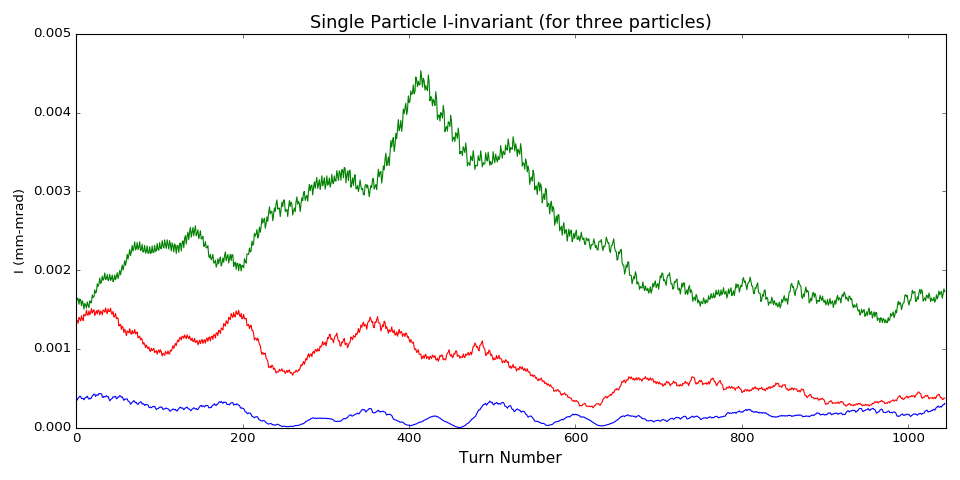

In [122]:
figc = plt.figure(figsize=(12,6))
cx = plt.gca()
cx.plot(np.arange(opts.turns+1),Iinv[0,:]*1e6,'-b')
cx.plot(np.arange(opts.turns+1),Iinv[50,:]*1e6,'-r')
cx.plot(np.arange(opts.turns+1),Iinv[4242,:]*1e6,'-g')
cx.set_xlim(-1,1+opts.turns)
cx.set_xlabel("Turn Number",fontsize=14)
cx.set_ylabel("I (mm-mrad)")
cx.set_title("Single Particle I-invariant (for three particles)")
plt.show()

<IPython.core.display.Javascript object>


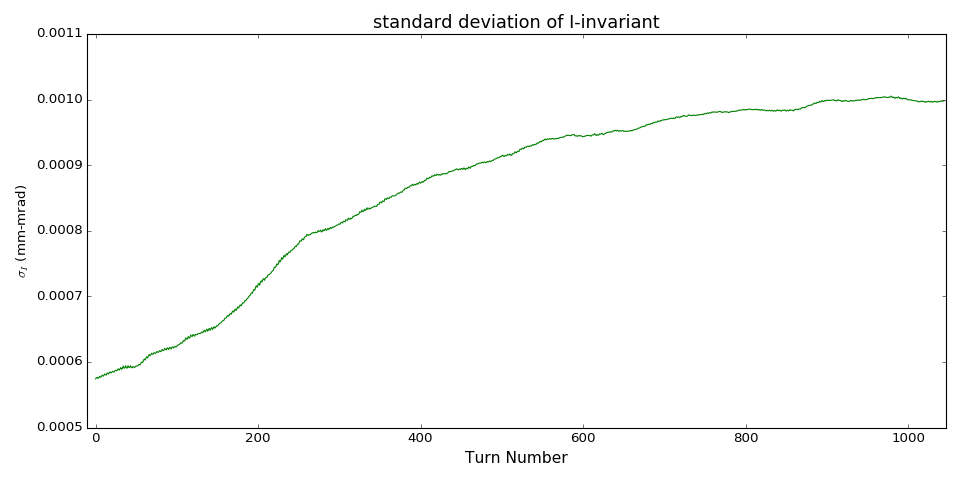

In [96]:
figc = plt.figure(figsize=(12,6))
cx = plt.gca()
cx.plot(np.arange(opts.turns+1),[np.std(Iinv[:,i])*1e6 for i in range(Iinv.shape[1])],'-',c='g')
cx.set_xlim(-10,opts.turns+2)
cx.set_xlabel("Turn Number",fontsize=14)
cx.set_ylabel("$\sigma_I$ (mm-mrad)")
cx.set_title("standard deviation of I-invariant")

plt.show()

# Analysis - Additional Invariant Plots

In [44]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


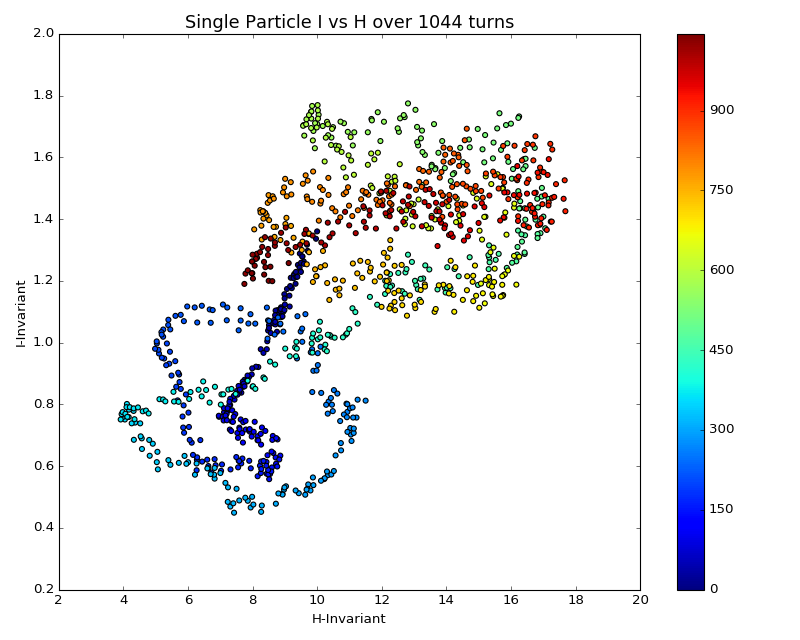

In [107]:
fig = plt.figure(figsize=(10,8))
plt.scatter(Hinv[60,:]*1e6,Iinv[60,:]*1e9,c=np.arange(len(Hinv[0,:])))
plt.colorbar()
plt.xlabel("H-Invariant")
plt.ylabel("I-Invariant")
plt.title("Single Particle I vs H over %s turns" % opts.turns)
plt.show()

<IPython.core.display.Javascript object>


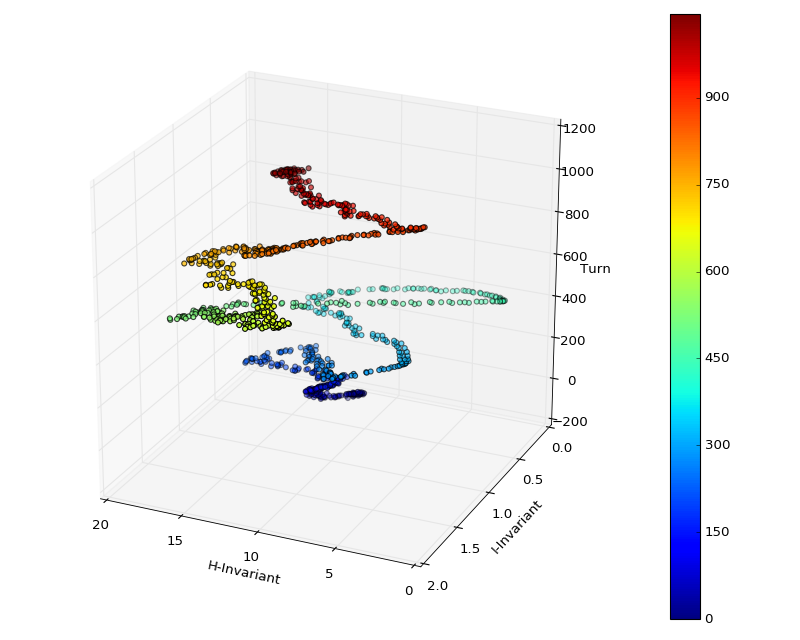

In [111]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(Hinv[10,:]*1e6,Iinv[10,:]*1e9,np.arange(len(Hinv[0,:])),c=np.arange(len(Hinv[0,:])))
ax.set_xlabel('H-Invariant')
ax.set_ylabel('I-Invariant')
ax.set_zlabel('Turn')

fig.colorbar(p)

plt.show()

<IPython.core.display.Javascript object>


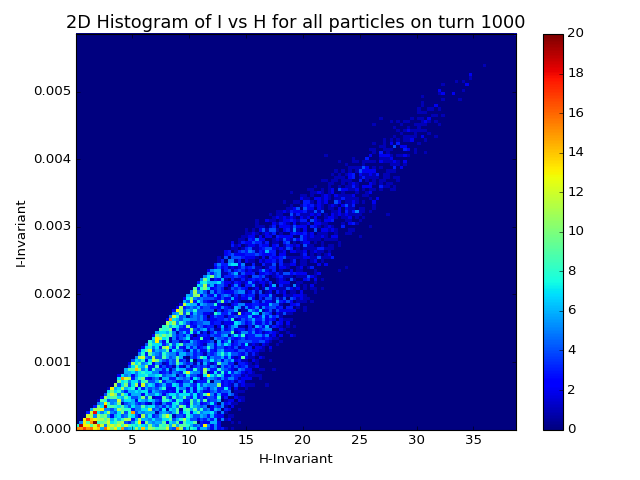

In [112]:
fig = plt.figure()
plt.hist2d(Hinv[:,1000]*1e6,Iinv[:,1000]*1e6,128)
plt.colorbar()
plt.xlabel("H-Invariant")
plt.ylabel("I-Invariant")
plt.title("2D Histogram of I vs H for all particles on turn 1000")
plt.show()

<IPython.core.display.Javascript object>


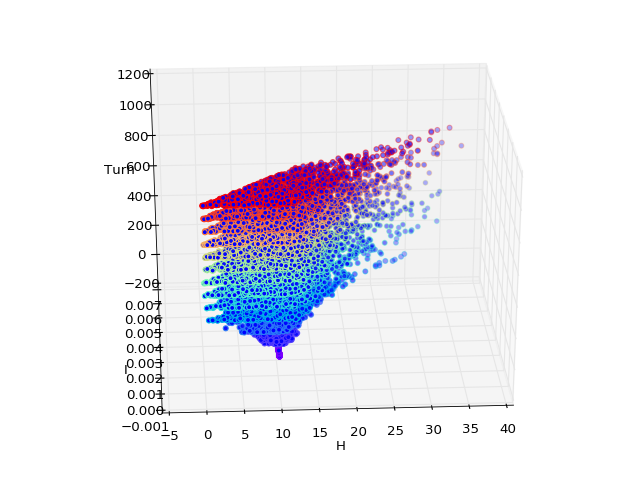

In [48]:
import matplotlib.cm as cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


turns = np.arange(0,1000,80)
colors = cm.rainbow(np.linspace(0,1,len(turns)))
for ni, c in zip(turns,colors):
    p = ax.scatter(Hinv[100:800,ni]*1e6,Iinv[100:800,ni]*1e6,ni,color=c)
ax.set_xlabel('H')
ax.set_ylabel('I')
ax.set_zlabel('Turn')
#fig.colorbar(p)

plt.show()

# Particle Data

In [63]:
# Function to store all particle output data to array, sorted, with lost particles removed from all turns
# array: Array[turnNumber,particleID,dimension]
def get_all_turns(directory,npart):
    turn = []
    lostParts = lostlist(directory,npart)

    for bunchFile in sorted(os.listdir(directory)):
        if bunchFile.endswith('.h5') and bunchFile.find('particles')!= -1:
            header, bunchIn = elliptic_sp.get_particles(directory + '/' + bunchFile)
            
            for lost in lostParts:
                rowlost = np.where(bunchIn[:,6] == lost)[0]
                try:
                    rowval = rowlost[0]
                except IndexError:
                    rowval = None
                if rowval:
                    bunchIn = np.delete(bunchIn,rowval,0)

                rowval = None
                
            sBunch = bunchIn[np.argsort(bunchIn[:,6])]
            turn.append(sBunch)
    return np.array(turn)

In [64]:
allTurns = get_all_turns('8-2_dQm0p1_NLL',10000)

particles_1044.h5
(9989, 7)


In [69]:
print allTurns.shape[0]

1045


<IPython.core.display.Javascript object>


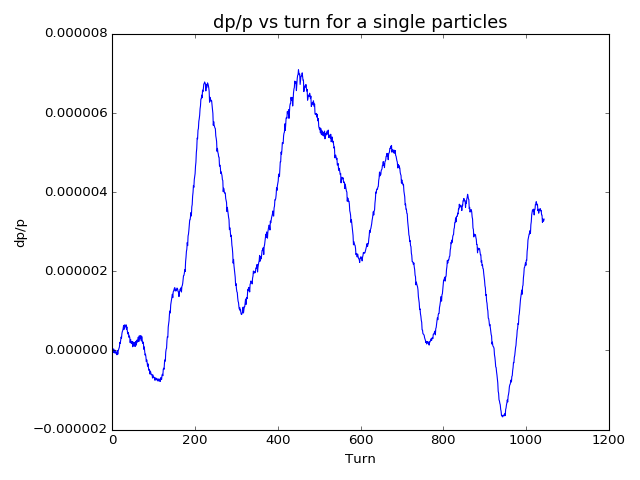

In [130]:
fig = plt.figure()

plt.plot(np.arange(allTurns.shape[0]),allTurns[:,4242,5])
plt.xlabel("Turn")
plt.ylabel("dp/p")
plt.title("dp/p vs turn for a single particles")
plt.show()

<IPython.core.display.Javascript object>


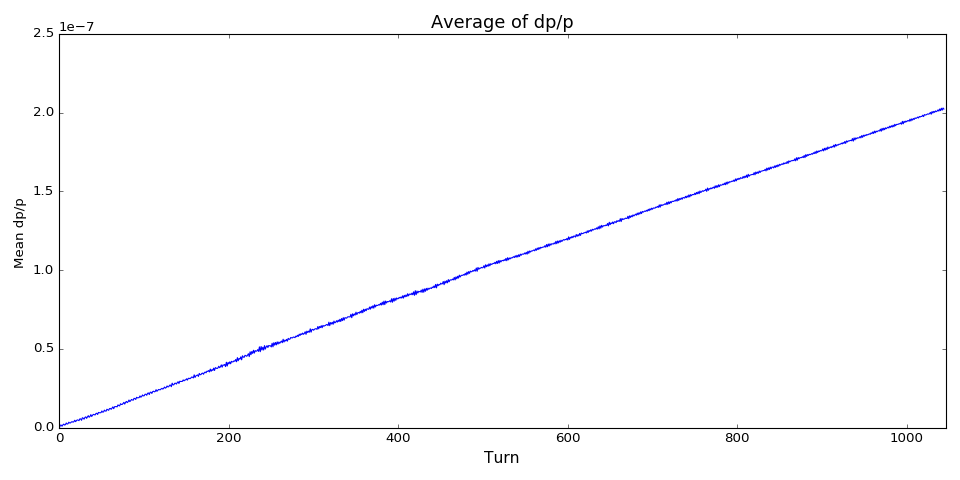

In [131]:
figc = plt.figure(figsize=(12,6))
cx = plt.gca()
cx.plot(np.arange(opts.turns+1),[np.average(allTurns[i,:,5]) for i in range(allTurns.shape[0])],'-')
cx.set_xlim(-1,opts.turns+2)
#cx.set_ylim(9.5,10.5)
cx.set_xlabel("Turn",fontsize=14)
cx.set_ylabel( "Mean dp/p ")
cx.set_title("Average of dp/p")
plt.show()